In [1]:
!pip install pycocotools

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.5-cp37-cp37m-linux_x86_64.whl size=373775 sha256=ee1b8231a1cd3bcc751a5cddbbdbbf51364aedc9340e2ba1db6e3f122ae64ba1
  Stored in directory: /root/.cache/pip/wheels/85/c4/f0/7128093a134f590e4383fd60cb484960878721d98b9a515317
Successfully built pycocotools


In [2]:
import os
import glob # return all the files which matches a particular pattern (search files where the filename matches a particular pattern by using wildcard characters)
import time
import numpy as np
from PIL import Image # library for image processing
from pathlib import Path  # object API for working with files and directories
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from pycocotools.coco import COCO

import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # selecting the device on which we will be working on
use_colab = None  # colab is not being used


In [3]:
!pip install fastai==2.4  # provides high level components which can provide state of the art results in standard deep learning domains

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.9/187.9 kB 2.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 909.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.5.27
    Uninstalling fastcore-1.5.27:
      Successfully uninstalled fastcore-1.5.27
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.9
    Uninstalling fastai-2.7.9:
      Successfully uninstalled fastai-2.7.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires torch<1.13.0,>=1.10.0, but you have torch 1.9.1 which is incompatible.


In [4]:
# For getting the path of the COCO Images

from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)  # for getting the coco image set
coco_path = str(coco_path) + "/train_sample"  # for the training set
use_colab = True

In [5]:
if use_colab == True:
  path = coco_path
else:
  path = "Your path to the dataset"



paths = glob.glob(path+"/*.jpg") #For extracting all the COCo dataset images
np.random.seed(69)  # Seeding for reproducible results
paths_subset = np.random.choice(paths,10000, replace = False)  # randomly chooses 10000 images from the dataset
rand_idxs = np.random.permutation(10000) # suffling the indexes
train_idxs = rand_idxs[:8000] # using the first 8000 images for training 
val_idxs = rand_idxs[8000:] # using the last 2000 images for validation 
train_paths = paths_subset[train_idxs]  # training dataset
val_paths = paths_subset[val_idxs]  # validation dataset
print(len(train_paths),len(val_paths))  # printing the size of each of the dataset


8000 2000


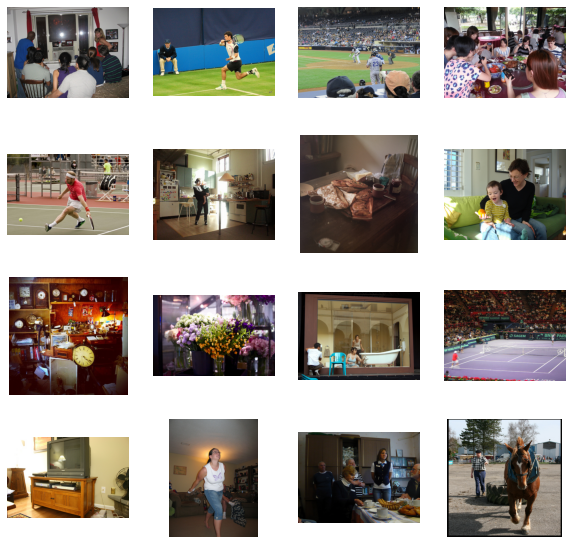

In [6]:
# For seeing the images

_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths): # flatten is used to return a flattened version of the array
    ax.imshow(Image.open(img_path))
    ax.axis("off")  # for turning off the axis

In [7]:
# For making Datasets and DataLoaders

SIZE = 256
class ColorizationDataset(Dataset):
  def __init__(self,paths,split='train'):
    if split == 'train':  # data augmentation for the training dataset
      # transformations is being applied to the input image
      self.transforms = transforms.Compose([transforms.Resize((SIZE,SIZE), Image.BICUBIC),
                                            transforms.RandomHorizontalFlip(),  # Data augmentation
                                            ])
    elif split == 'val':
      self.transforms = transforms.Resize((SIZE,SIZE), Image.BICUBIC)

    self.split = split
    self.size = SIZE
    self.paths = paths
  
  def __getitem__(self,idx):
    img = Image.open(self.paths[idx]).convert("RGB")# getting the image of index idx and converting it into "RGB" format
    img = self.transforms(img)  # applying the transformations on the image
    img = np.array(img) # converting img to a numpy array
    img_lab = rgb2lab(img).astype("float32")  # converting RGB to L*a*b
    img_lab = transforms.ToTensor()(img_lab)  # converts the numpy array into a tensor
    L = img_lab[[0], ...] / 50. - 1.  # Between -1 and 1  # bringing value in the range -1 to 1
    ab = img_lab[[1,2], ...] / 110. # Between -1 and 1

    return {'L':L, 'ab':ab}

  def __len__(self):
    return len(self.paths)

def make_dataloaders(batch_size = 16,n_workers = 4, pin_memory = True, **kwargs): # A handy fucntion to make our dataloaders
  dataset = ColorizationDataset(**kwargs) # dataset from where the data need to be obtained
  dataloader = DataLoader(dataset, batch_size = batch_size, num_workers = n_workers,pin_memory = pin_memory)
  # num_workers is the number of sub-processes to use by cpu for data loading
  return dataloader

In [8]:
# For the training and validation set
train_dl = make_dataloaders(paths = train_paths, split = 'train') # for the training set
val_dl = make_dataloaders(paths = val_paths, split = 'val') # for the validation set

data = next(iter(train_dl)) # for going to the next dataset
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape) # 16 is the batch size, 1 is the 1st channel[L] and 2 is the 2nd channel[a*,b*]
print(len(train_dl), len(val_dl))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self._drop_last = loader.drop_last
/opt/conda/lib/python3.7/site-packages/ipykernel_laun

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


In [9]:
# U-NET
# UNet is a convolutional neural network architecture that expanded with few changes in CNN architecture. It was invented to deal with biomedical images where the target is not only 
# to classify whether there is an in_finalection or not but also to identify the area of in_finalection

In [10]:
# # For building the Generator model
# # Creating the Unet layer
class UnetBlock(nn.Module):
  # nf final number of channels after the convolution layers
  # ni initial number of channels on which the convolution operation is to be used
  # sub_module stores the model that has been  built till now
  # dropout is used to ensure whether to apply dropout or not
  def __init__(self,nf,ni, submodule = None, input_c = None, dropout = False, innermost = False, outermost = False):  # initialization
    super().__init__()
    self.outermost = outermost
    if input_c is None: input_c = nf
    downconv = nn.Conv2d(input_c, ni, kernel_size = 4, stride = 2, padding = 1, bias = False)
    downrelu = nn.LeakyReLU(0.2,True)
    downnorm = nn.BatchNorm2d(ni)
    uprelu = nn.ReLU(True)
    upnorm = nn.BatchNorm2d(nf)

    if outermost: # for creating the outermost layers
      upconv = nn.ConvTranspose2d(ni*2, nf, kernel_size =4, stride = 2, padding = 1)
      down = [downconv]
      up = [uprelu, upconv, nn.Tanh()]
      model = down + [submodule] + up
    elif innermost: # for creating the innermost layer
      upconv = nn.ConvTranspose2d(ni, nf, kernel_size = 4, stride = 2, padding = 1, bias = False)
      down = [downrelu, downconv]
      up = [uprelu, upconv, upnorm]
      model = down + up
    else: # for creating the intermediate layers
      upconv = nn.ConvTranspose2d(ni*2, nf, kernel_size =4, stride = 2, padding =1, bias = False) # for the upper layer
      down = [downrelu, downconv, downnorm] # lower part of the model
      up = [uprelu, upconv, upnorm] # upper part of the model
      if dropout: up += [nn.Dropout(0.5)] # for applying the dropout layer
      model = down + [submodule] + up # joining the different layers
    self.model = nn.Sequential(*model)  # storing the model in self.model

  def forward(self,x):
    if self.outermost:
      return self.model(x)  # for the output layer, no concatenation
    else:
      return torch.cat([x, self.model(x)], 1) # the input and the output of the model is being concatenated before returning

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):  # n down is the total number of layers in total
        # 1 innermost + 3 down and 3 up + 3 conv layers down and up + 1 outemost layer for down and up
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)  # innermost is the middle layer of the Unet architecture formed
        for _ in range(n_down - 5): # creating the 3 up and down layers over the innermost layer
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8 # 64*8
        for _ in range(3):  # above the layers already built
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block) # convolution layers with decreasing channel numbers
            out_filters //= 2 # out_filters are being reduced
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)  # for the outermost layer
    
    def forward(self, x):
        return self.model(x)  # returning the model
  


In [11]:
# x = Unet()

In [12]:
# x

In [21]:
!pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 723.9/723.9 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 26.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.7.7 requires torch>=1.9.*, but you have torch 1.4.0+cu100 which is incompatible.
kornia 0.5.8 requires torch>=1.6.0, but you have torch 1.4.0+cu100 which is incompatible.
fastai 2.4 requires torch<1.10,>=1.7.0, but you have torch 1.4

In [22]:
# !pip install fastai==2.4
from torch.utils.model_zoo import load_url as load_state_dict_from_url
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [23]:
def build_res_unet(n_input=1, n_output=2, size=256): # for building the resnet architecture
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [25]:
# Creating the discriminator

class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)] # 3 channel input and 64 channel output
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)  # for creating the following layers
                                                                                                                    # for the last layer, stride = 1 is used
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # for the last layer
                                                                                             # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)  # sequential model is used                                                 
    
    # Layers are being created for the discriminator
    def get_layers(self, ni, n_final, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, n_final, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(n_final)]  # if norm need to be added, then add normalization
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [26]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [27]:
# Dummy Running the discriminator

discriminator = PatchDiscriminator(3) # L, a*, b* 3 channels is being passed, so input channel is 3
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape
# output shape contain 1 channel

torch.Size([16, 1, 30, 30])

In [28]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))  # parameters not trained by the optimizer but it is being stored in the variable 
        self.register_buffer('fake_label', torch.tensor(fake_label))  # parameters not trained by the optimizer but it is being stored in the variable 
        # Choosing the type of loss function to be used for the evaluation of the model
        if gan_mode == 'vanilla': 
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label  # saving the value from the constant tensors
        else:
            labels = self.fake_label
        return labels.expand_as(preds)  # expands the shape as the shape of preds
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real) # prediction is being given and the target_is_real is being given which determines the actual label
        loss = self.loss(preds, labels) # for calculating the loss from the loss function (pred and labels)
        return loss

In [29]:
# for initializing the weights
# norm means weights are initialized from normal distribution
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__  # for getting all the class names present in m
        if hasattr(m, 'weight') and 'Conv' in classname:  # initialize weight for the conv layers and any attribute having weight
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)  # giving a normal initialization # the weights get initialized
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)  # for xaviers initialization
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')  # for kaiming initialization
            
            if hasattr(m, 'bias') and m.bias is not None: # checking bias and ensuring it is not none
                nn.init.constant_(m.bias.data, 0.0) # initalizing the bias with constant value 0.0
        elif 'BatchNorm2d' in classname:  # for the batch normalization
            nn.init.normal_(m.weight.data, 1., gain)  # weight is having normal initialization
            nn.init.constant_(m.bias.data, 0.)  # bias is having constant initialization
            
    net.apply(init_func)  # apply is kind of a map, the input is a function which the 'apply" function applies to model "net" 
    print(f"model initialized with {init} initialization")
    return net  # returning of the modified model

def init_model(model, device):
    model = model.to(device)  # applying the device to the model
    model = init_weights(model) # initializing the weights in the model
    return model

In [30]:
# Combining the different components to form the model 

class MainModel(nn.Module):
  # net_G -> whether previously the Generator model is being passed or not
  # lr_G -> learning rate for the generator function
  # lr_D -> learning rate for the discriminator function
  # beta1 and beta2 are parameters for ADAM optimizer
  # lambda_L1 is the weight given to the L1 loss in the final loss prediction from the loss function

    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # setting up the device
        self.lambda_L1 = lambda_L1
        
        if net_G is None: # if no generator fucntion is passed, then this creates a new generator function
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device) # new generator function is being created
        else:
            self.net_G = net_G.to(self.device)  # if already generator function has been passed, then apply the device
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device) # for creating a Discriminator 
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device) # for creating the loss function
        self.L1criterion = nn.L1Loss()  # for the L1 loss
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2)) # gradient descent for the Generator Function
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2)) # gradient descent for the Discriminator Function
    
    def set_requires_grad(self, model, requires_grad=True): # making require grad for all the parameters in the model to be True
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):  # seperately storing the L and "ab" channels of the image
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):  # generating the image using the Generator Function
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)  # concatenating the generated and the black n white image together
        fake_preds = self.net_D(fake_image.detach())  # predicts the label of the fake_image (whether it is "real" or "fake") # detach used to remove it from the current computational Graph
        self.loss_D_fake = self.GANcriterion(fake_preds, False) # finding the loss
        real_image = torch.cat([self.L, self.ab], dim=1)  # real image
        real_preds = self.net_D(real_image) # prediction of the image using the Discriminator 
        self.loss_D_real = self.GANcriterion(real_preds, True)  # finding the loss
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5 # 0.5 applies to both LSGAN and DCGAN. criterionGAN is a class for both objectives. 
                                                                  # 0.5 should make no big difference. In practice, we divide the objective by 2 while optimizing D, 
                                                                  # which slows down the rate at which D learns relatively to G.
        self.loss_D.backward()  # calculating the backward flow of Discriminator
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)  # concatenating the generated and the black n white image together
        fake_preds = self.net_D(fake_image) # predicts the label from the discriminator
        self.loss_G_GAN = self.GANcriterion(fake_preds, True) # finding the loss
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1  # L1 loss is being calculated
        self.loss_G = self.loss_G_GAN + self.loss_G_L1  # total loss GAN + L1
        self.loss_G.backward()  # calculating the backward flow of Generator
    
    def optimize(self):
        self.forward()  # for the forward function
        self.net_D.train()  # sets the model to train
        self.set_requires_grad(self.net_D, True)  # setting the gradients to be true
        self.opt_D.zero_grad()  # zero_grad for the previous iterations
        self.backward_D() # for the backward Discriminator function
        self.opt_D.step() # for the step function # step function updates the weights and biases present in the model
        
        self.net_G.train()  # sets the model to train
        self.set_requires_grad(self.net_D, False) # setting the gradients to be true
        self.opt_G.zero_grad()  # zero_grad for the previous iterations
        self.backward_G() # for the backward Generator function
        self.opt_G.step() # for the step function # step function updates the weights and biases present in the model

In [31]:
# For displaying all the losses and the output

class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):  # for reseting the count, avg and sum
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1): # for updating
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters(): # for the loss calculation
    # contains all kinds of loss

    # For the Discriminator Loss
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    # For the Generator Loss
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    # returning all the losses
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items(): # getting the loss name and the loss meter
        loss = getattr(model, loss_name)  # getattr returns the specified attribute from the specified object
        loss_meter.update(loss.item(), count=count) # update different losses

def lab_to_rgb(L, ab):  # converting all the Lab images to rgb images
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.  # initially the value was divided by 50 to bring it into the range of -1 to 1
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy() # concatenating horizontally
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0) # stacking images vertically

# For Visualizing the image
    
def visualize(model, data, save=True):
    model.net_G.eval()  # to set the model into evaluation mode
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()  # getting the fake image from the Generator (outputs a*,b*) 
    real_color = model.ab # the ab channel
    L = model.L # the L channel
    fake_imgs = lab_to_rgb(L, fake_color) # fake image
    real_imgs = lab_to_rgb(L, real_color) # real image
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray') # printing the black n white image
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i]) # printing the fake image generated from the Generator Function
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i]) # printing the real image given as input
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")  # for saving the image
        
def log_results(loss_meter_dict): # for displaying the Loss
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [33]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):# the resnet is being pretrained to account for the L1 loss
    for e in range(epochs):# epochs
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)# seperating L and a,b
            preds = net_G(L) # finding the output using the Generator function
            loss = criterion(preds, ab) # calculating the LOSS
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0)) # updating the loss value
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)# building the resnet model
opt = optim.Adam(net_G.parameters(), lr=1e-4)# selecting the optimizer
criterion = nn.L1Loss()# for the L1 loss
pretrain_generator(net_G, train_dl, opt, criterion, 2)# creating the Generator Function
torch.save(net_G.state_dict(), "res18-unet.pt") # saving the parameters of the model

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/2
L1 Loss: 0.08608


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/2
L1 Loss: 0.08278


model initialized with norm initialization


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 1/1
Iteration 200/500
loss_D_fake: 0.48037
loss_D_real: 0.47569
loss_D: 0.47803
loss_G_GAN: 1.60078
loss_G_L1: 9.09531
loss_G: 10.69609


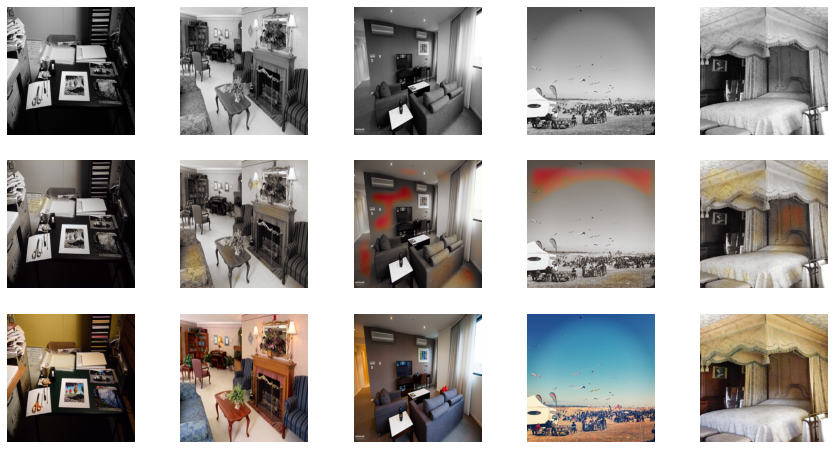


Epoch 1/1
Iteration 400/500
loss_D_fake: 0.48576
loss_D_real: 0.48448
loss_D: 0.48512
loss_G_GAN: 1.56182
loss_G_L1: 9.33199
loss_G: 10.89381


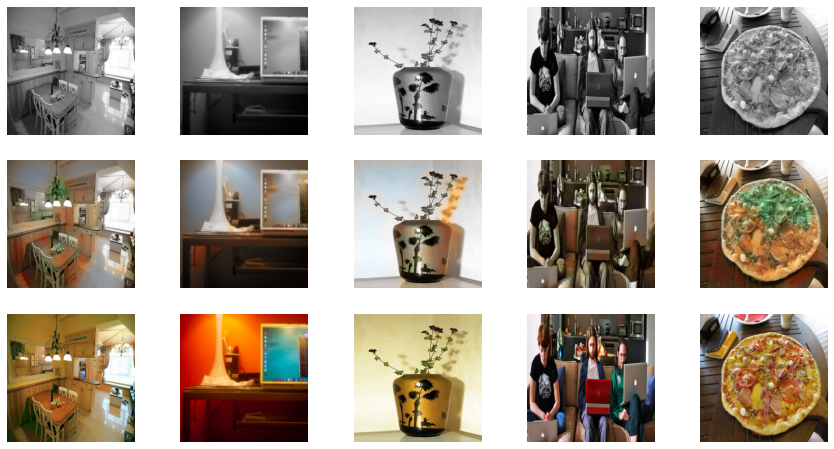

In [35]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) # for L and a*,b*
            model.optimize()  # optimize the model
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1  # increase the count of i
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

# model = MainModel() # creating object for the main model
# train_model(model, train_dl, 100) # train_dl is the training dataset # 100 is the number of epoch

net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device)) # loading the weights from the saved model
model = MainModel(net_G=net_G) # passing the Generator Function
train_model(model, train_dl, 1)